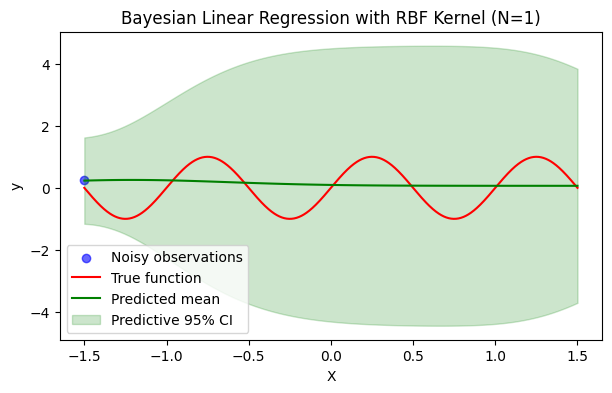

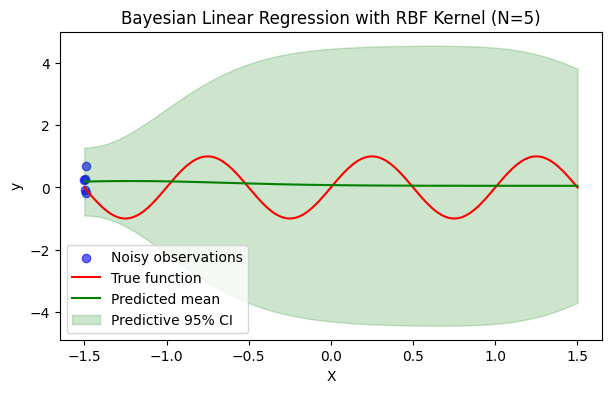

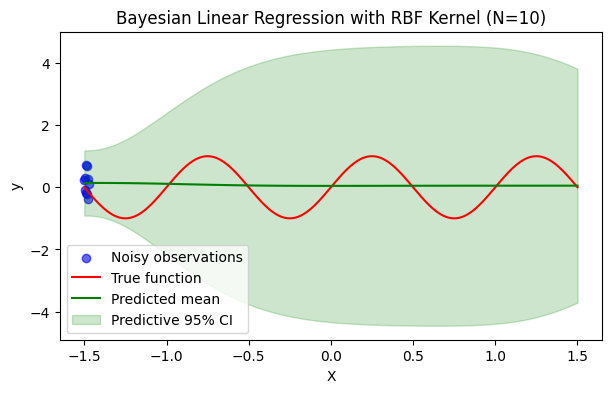

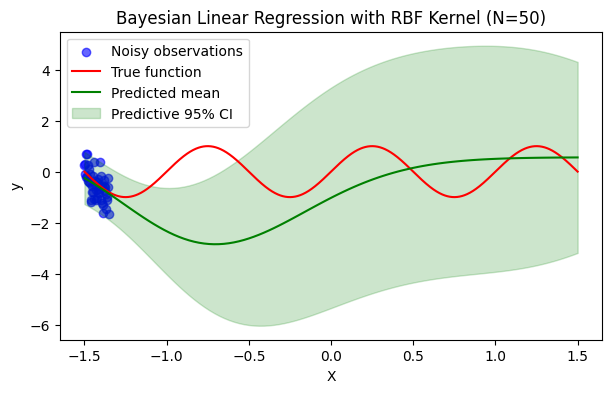

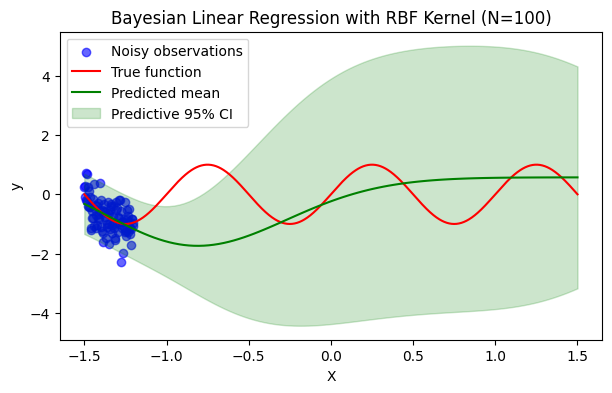

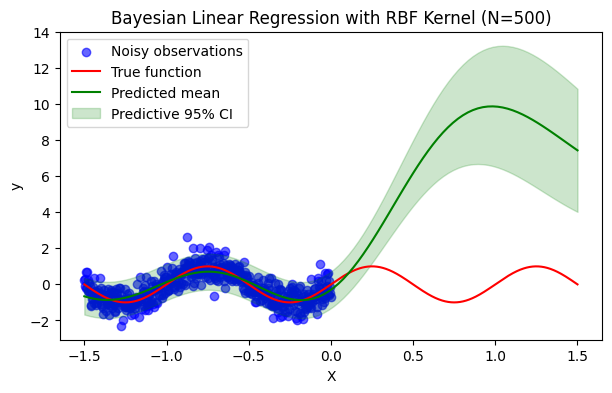

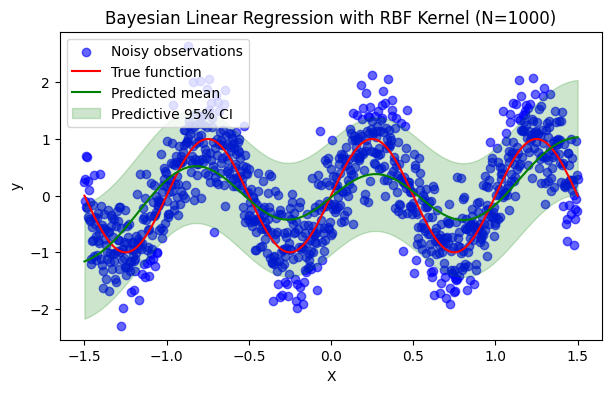

In [4]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BayesianLinearRegressionRBF:
    """ Bayesian linear regression with RBF kernel """

    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float, rbf_centers: np.ndarray, rbf_length_scale: float):
        # Initialize prior mean and covariance
        self.prior_mean = prior_mean                   # m0
        self.prior_cov = prior_cov                     # S0
        self.noise_var = noise_var                     # σ_noise^2
        self.rbf_centers = rbf_centers
        self.rbf_length_scale = rbf_length_scale

        # define prior distribution
        self.prior = multivariate_normal(mean=self.prior_mean, cov=self.prior_cov)

        # 🟩 ADDED CODE — initialize posterior as prior
        self.post_mean = self.prior_mean.copy()        # mN
        self.post_cov = self.prior_cov.copy()          # SN
        self.param_posterior = self.prior              # Multivariate normal posterior

    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix using RBF kernel features.
        """
        # construct Φ(X)
        features = np.array(features).reshape(-1, 1)
        rbf_features = np.exp(-0.5 * ((features - self.rbf_centers.reshape(1, -1)) ** 2) / (self.rbf_length_scale ** 2))
        bias = np.ones((features.shape[0], 1))
        design_matrix = np.hstack((bias, rbf_features))   # Add bias column
        return design_matrix

    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets
        """
        # apply posterior update equations
        targets = np.array(targets).reshape(-1, 1)
        design_matrix = self.compute_design_matrix(features)

        S0_inv = np.linalg.inv(self.prior_cov)
        SN_inv = S0_inv + (1 / self.noise_var) * (design_matrix.T @ design_matrix)
        self.post_cov = np.linalg.inv(SN_inv)

        self.post_mean = self.post_cov @ (S0_inv @ self.prior_mean.reshape(-1,1) +
                                          (1 / self.noise_var) * design_matrix.T @ targets)
        self.post_mean = self.post_mean.flatten()

        self.param_posterior = multivariate_normal(mean=self.post_mean, cov=self.post_cov)

    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint
        """
        # compute predictive mean and variance
        design_matrix = self.compute_design_matrix(features)

        pred_mean = design_matrix @ self.post_mean
        pred_cov = (design_matrix @ self.post_cov @ design_matrix.T) + self.noise_var

        # use univariate_normal for output distribution
        pred_std = np.sqrt(np.diag(pred_cov))
        pred_posterior = univariate_normal(loc=pred_mean, scale=pred_std)
        return pred_posterior

    @staticmethod
    def visualize(X, y, X_sampled, y_noisy, X_test, pred_posterior, n):
        plt.figure(figsize=(7,4))
        plt.scatter(X_sampled, y_noisy, label="Noisy observations", color='blue', alpha=0.6)
        plt.plot(X, y, color='r', label="True function")
        plt.plot(X_test, pred_posterior.mean(), color='green', label="Predicted mean")
        plt.fill_between(X_test,
                         pred_posterior.mean() - 2 * pred_posterior.std(),
                         pred_posterior.mean() + 2 * pred_posterior.std(),
                         color='green', alpha=0.2, label="Predictive 95% CI")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.title(f"Bayesian Linear Regression with RBF Kernel (N={n})")
        plt.legend()
        plt.show()


# ------------------- MAIN SCRIPT -------------------

np.random.seed(42)

# generate true function and noisy data
X = np.linspace(-1.5, 1.5, 1000)
y = np.sin(2 * np.pi * X)
y_noisy = y + np.random.normal(0, 0.5, size=y.shape)

# define RBF centers and kernel parameters
rbf_centers = np.linspace(-1.5, 1.5, 15)
rbf_length_scale = 0.5

# set up priors and noise variance
prior_mean = np.zeros(len(rbf_centers) + 1)
prior_cov = np.eye(len(rbf_centers) + 1) * 1.0
noise_var = 0.5 ** 2

# loop for increasing training data
n_train_samples = [1, 5, 10, 50, 100, 500, 1000]
final_result = {'X': [], 'y': [], 'y_stddev': []}

for n in n_train_samples:
    model = BayesianLinearRegressionRBF(prior_mean, prior_cov, noise_var, rbf_centers, rbf_length_scale)
    X_sampled = X[:n]
    y_sampled = y[:n]
    y_noisy_sampled = y_noisy[:n]

    model.update_posterior(X_sampled, y_noisy_sampled)
    X_test = np.linspace(-1.5, 1.5, 100)
    pred_posterior = model.predict(X_test)

    if n == 1000:
        final_result['X'] = X_test
        final_result['y'] = pred_posterior.mean()
        final_result['y_stddev'] = pred_posterior.std()
        pd.DataFrame(final_result).to_csv('output.csv', index=False)

    BayesianLinearRegressionRBF.visualize(X, y, X_sampled, y_noisy_sampled, X_test, pred_posterior, n)
